In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [3]:
# pick one timepoint
# e.g. if you pick 4, then we will load DEPI data with labels like "LOD V4" or "V4"
depi_timepoint = 81
NLM_timepoint = 58


In [4]:
daisy_plot_font_size = 12

positive_connection_color = "pink" # AA > BB
negative_connection_color = "skyblue" # AA < BB

node_dist = 6
node_radius = 1.5
max_connection_width = 20

default_param_color = "white"
param_colors = {
    "Phi2": "cornflowerblue",#"lime",
    "NPQt": "cornflowerblue",#"lime",
    "qL": "cornflowerblue",#"lightpink",
    "normalized_ECSt": "cornflowerblue",#"yellow",
    "gHplus": "cornflowerblue",# "lightpink",
    "normalized_vHplus": "cornflowerblue",# "coral",
    "P700": "red",#"mediumpurple",
    "kP700": "cornflowerblue",#"limegreen",
    "SPAD":"orange",#"skyblue",
    
    
    "depi_phi2":"cornflowerblue", #"red",
    "depi_NPQt": "cornflowerblue",##"lime",
    "depi_qEt": "cornflowerblue",
    "depi_qIt": "cornflowerblue",#"limegreen",
    "depi_qL":"cornflowerblue", #"lightpink",
    "depi_NLM": "lightgrey",
    "Relative_CEF": "cornflowerblue",#"red",
    "Y_NA": "red",
    
    
}


# for some parameters, the label that appears in the plot 
# will be different than the column name in the data
param_labels = {
    
    # column name in data: label in plot
    "Phi2": "$\mathregular{Φ_{II}}$",
    "NPQt": "$\mathregular{NPQ_{t}}$",
    "qL": "$\mathregular{q_{L}}$",
    "normalized_ECSt":"$\it{pmf}$",
    #"$\mathregular{ECS_{t}}$"
    "gHplus": "$\it{g}\mathregular{_{H}}$+",
    "normalized_vHplus": "$\it{v}\mathregular{_{H}}$+",
    "P700": "$\mathregular{P700^{+}}$",
    "kP700": "$\mathregular{k_{b6f}}$",
    "Relative_CEF":"CEF",
#     "Y_NA": "$\mathregular{Y_{NA}}$",
    "Y_NA": "$\mathregular{PSI{or}}$",
  
    "depi_phi2": "Pheno A",#"DEPI $\mathregular{Φ_{II}}$",
    "depi_NPQt": "Pheno B",#"DEPI $\mathregular{NPQ_{t}}$",
    "depi_qEt": "DEPI $\mathregular{qE_{t}}$",
    "depi_qIt": "DEPI $\mathregular{qI_{t}}$",
    "depi_qL": "DEPI $\mathregular{q_{L}}$",
    "depi_NLM": "NLM",
    

}

    
# selection for the position of parameters around circle
param_order = [
   
    "depi_phi2","depi_NPQt","depi_qEt","depi_qIt","depi_qL",
    "normalized_ECSt","gHplus","normalized_vHplus","kP700","Relative_CEF", "Y_NA","depi_NLM","SPAD"
]


In [5]:
# load multispeq data

data_files = {
    # condition, [raw data, normalized lod scores, lod thresholds]
    "CT": [
        "CT_reprocessed_multispeq_all_papras_reps_gen_rdr_final.csv",
        "lod_CT_reprocessed_multispeq_all_paras_reps_final.csv",
        "lod_threshold_CT_reprocessed_multispeq_all_paras_reps_final.csv"
    ],
    "LT": [
        "LT_reprocessed_multispeq_all_papras_reps_gen_rdr_final.csv",
        "lod_LT_reprocessed_multispeq_all_paras_reps_final.csv",
        "lod_threshold_LT_reprocessed_multispeq_all_paras_reps_final.csv"
    ]
}

all_raw_dataframes = {}
all_lod_dataframes = {}
all_th_dataframes = {}

for condition,filenames in data_files.items():
    all_raw_dataframes[condition] = [pd.read_csv(filenames[0])]
    
    # load lod scores
    df = pd.read_csv(filenames[1])
    th_df = pd.read_csv(filenames[2])
    for col in df.columns:
        if col.startswith("LOD "):
            df[col] = df[col] * th_df[col[4:]].values[0]
    all_lod_dataframes[condition] = df
    all_th_dataframes[condition] = th_df

In [6]:
# load photosynthetic depi data 


# labels that appear in filenames for depi data
depi_param_names_in_filenames = ["phi2","NPQt","qEt","qIt","qL"]
#depi_param_names_in_filenames = ["phi2","NPQt","qEt","qIt","qL","NLM"]

# another version of the labels above
# we add a prefix to distinguish depi params from multispeq params
unique_depi_param_names = ["depi_" + p for p in depi_param_names_in_filenames]


# load all depi data
for condition in ["CT","LT"]:
    depi_raw_dataframe_for_condition = pd.DataFrame()
    
    for simple_param_name,unique_param_name in zip(depi_param_names_in_filenames,unique_depi_param_names):
        
        # load raw data
        if depi_timepoint <= 28:
            raw_fn_form = "combined_{0}_day1_gen_include_rdr.csv"
        else:
            if condition == "CT":
                if simple_param_name == "qL":
                    raw_fn_form = "control_updated_{0}_three_days_gen_include_rdr_2_F_A.csv"
                else:
                    raw_fn_form = "contol_updated_{0}_three_days_gen_include_rdr_2.csv"
            else:
                raw_fn_form = "{0}_three_days_gen_include_rdr.csv"
        raw_filename = raw_fn_form.format(simple_param_name)
        depi_raw_df = pd.read_csv(raw_filename, low_memory=False)
        
        # load lod file and consider only one timepoint
        if depi_timepoint <= 28:
            lod_fn_form = "longform_lod_{0}_day1_combined.csv"
        else:
            if condition == "CT":
                lod_fn_form = "control_updated_{0}_longform_lod.csv"
            else:
                lod_fn_form = "longform_lod_{0}_three_days.csv"
        lod_filename = lod_fn_form.format(simple_param_name)
        depi_lod_df = pd.read_csv(lod_filename, low_memory=False)
        t_name = "LOD V" + str(depi_timepoint)
        depi_lod_df = depi_lod_df[depi_lod_df["Phenotype"] == t_name]
            
        # load threshold file
        if condition=="CT":
            th_fn_form = "lod_thresholds_control_updated_{0}_84tps_1000p.csv"
        else:
            th_fn_form = "lod_thresholds_{0}_84tps_1000p.csv"
        th_filename = th_fn_form.format(simple_param_name)
        depi_th_df = pd.read_csv(th_filename, low_memory=False)            
        
        # add a new dataframe to the list of raw dataframes for this condition
        timepoint_col = "V"+str(depi_timepoint)
        one_timepoint_column_df = depi_raw_df[[timepoint_col]]
        one_timepoint_column_df.columns = [unique_param_name]
        hapmap_df = depi_raw_df.loc[:,~pd.isnull(depi_raw_df.loc[0,:])]
        one_timepoint_raw_df = pd.concat( [one_timepoint_column_df, hapmap_df], axis=1 )
        all_raw_dataframes[condition].append(one_timepoint_raw_df)
        
        # add a new column to the master lod dataframe
        df = all_lod_dataframes[condition]
        new_column_name = "LOD " + unique_param_name
        df[new_column_name] = np.nan
        for row in df.index:
            chrom,pos = df.loc[row,["chr","pos (cM)"]]
            matching_depi_rows = depi_lod_df[(depi_lod_df["Chromosome"] == chrom) & (depi_lod_df["Position"] == pos)].index
            if len(matching_depi_rows) > 0:
                df.loc[row,new_column_name] = depi_lod_df.loc[matching_depi_rows[0],"LOD"]
                
        # add a new column to the master threshold dataframe
        df = all_th_dataframes[condition]
        in_col = "V" + str(depi_timepoint)
        df.loc[0,unique_param_name] = float(depi_th_df.loc[0,in_col])
        

In [7]:
# load NLM data 


# labels that appear in filenames for depi data
depi_param_names_in_filenames = ["NLM"]
#depi_param_names_in_filenames = ["phi2","NPQt","qEt","qIt","qL","NLM"]

# another version of the labels above
# we add a prefix to distinguish depi params from multispeq params
unique_depi_param_names = ["depi_" + p for p in depi_param_names_in_filenames]


# load all depi data
for condition in ["CT","LT"]:
    depi_raw_dataframe_for_condition = pd.DataFrame()
    
    for simple_param_name,unique_param_name in zip(depi_param_names_in_filenames,unique_depi_param_names):
        
        # load raw data
        if NLM_timepoint <= 28:
            raw_fn_form = "combined_{0}_day1_gen_include_rdr.csv"
        else:
            if condition == "CT":
                if simple_param_name == "qL":
                    raw_fn_form = "control_updated_{0}_three_days_gen_include_rdr_2_F_A.csv"
                else:
                    raw_fn_form = "contol_updated_{0}_three_days_gen_include_rdr_2.csv"
            else:
                raw_fn_form = "{0}_three_days_gen_include_rdr.csv"
        raw_filename = raw_fn_form.format(simple_param_name)
        depi_raw_df = pd.read_csv(raw_filename, low_memory=False)
        
        # load lod file and consider only one timepoint
        if NLM_timepoint <= 28:
            lod_fn_form = "longform_lod_{0}_day1_combined.csv"
        else:
            if condition == "CT":
                lod_fn_form = "control_updated_{0}_longform_lod.csv"
            else:
                lod_fn_form = "longform_lod_{0}_three_days.csv"
        lod_filename = lod_fn_form.format(simple_param_name)
        depi_lod_df = pd.read_csv(lod_filename, low_memory=False)
        t_name = "LOD V" + str(NLM_timepoint)
        depi_lod_df = depi_lod_df[depi_lod_df["Phenotype"] == t_name]
            
        # load threshold file
        if condition=="CT":
            th_fn_form = "lod_thresholds_control_updated_{0}_84tps_1000p.csv"
        else:
            th_fn_form = "lod_thresholds_{0}_84tps_1000p.csv"
        th_filename = th_fn_form.format(simple_param_name)
        depi_th_df = pd.read_csv(th_filename, low_memory=False)            
        
        # add a new dataframe to the list of raw dataframes for this condition
        timepoint_col = "V"+str(NLM_timepoint)
        one_timepoint_column_df = depi_raw_df[[timepoint_col]]
        one_timepoint_column_df.columns = [unique_param_name]
        hapmap_df = depi_raw_df.loc[:,~pd.isnull(depi_raw_df.loc[0,:])]
        one_timepoint_raw_df = pd.concat( [one_timepoint_column_df, hapmap_df], axis=1 )
        all_raw_dataframes[condition].append(one_timepoint_raw_df)
        
        # add a new column to the master lod dataframe
        df = all_lod_dataframes[condition]
        new_column_name = "LOD " + unique_param_name
        df[new_column_name] = np.nan
        for row in df.index:
            chrom,pos = df.loc[row,["chr","pos (cM)"]]
            matching_depi_rows = depi_lod_df[(depi_lod_df["Chromosome"] == chrom) & (depi_lod_df["Position"] == pos)].index
            if len(matching_depi_rows) > 0:
                df.loc[row,new_column_name] = depi_lod_df.loc[matching_depi_rows[0],"LOD"]
                
        # add a new column to the master threshold dataframe
        df = all_th_dataframes[condition]
        in_col = "V" + str(NLM_timepoint)
        df.loc[0,unique_param_name] = float(depi_th_df.loc[0,in_col])

In [8]:
# reformat data
for df_list in all_raw_dataframes.values():
    for df in df_list:
        
        # treat chromosomes and positions (first 2 rows) as numbers
        for row in [0,1]:
            df.loc[row,:] = pd.to_numeric(df.loc[row,:])

        # treat phenotypes (some columns) as numbers
        for col in df.loc[:,pd.isnull(df.loc[0,:])].columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

In [15]:
# draw a circle with a label on an existing figure
def draw_node( ax, x, y, label, color ):
    ax.add_patch(plt.Circle(( x,y ), node_radius, color=color, 
                            lw=2,ec= "black"))
    ax.text(x,y,label,ha="center",va="center",fontsize=daisy_plot_font_size,color='black')
    
# draw a line from the origin on an existing figure
def draw_connection( ax, x,y, thickness, color, solid ):
    linestyle = "-" if solid else ":"
    ax.add_line(mlines.Line2D([0,x], [0,y], color=color, linewidth=thickness, zorder=-1, linestyle=linestyle))
    

# draw a figure where we have one +/- value for each param label
def circles_figure( center_label, params, values, solid_or_dashed, vmax=None ):
    if len(params) != len(values):
        raise Exception( "params and values must be the same length" )
    
    if vmax is None:
        vmax = max(abs(np.array(values)))
    
    da = np.pi * 2 / len(params)
    
    fig,ax = plt.subplots(figsize=(8,8))
    
    # for each label, draw one connection and one node
    for i,param in enumerate(params):
        value = values[i]
        label = param_labels[param] if param in param_labels.keys() else param
        
        conn_color = positive_connection_color if (value > 0) else negative_connection_color
        node_color = param_colors[param] if (param in param_colors.keys()) else default_param_color
        
        thickness = max_connection_width * min(1,(abs(value)/vmax))
        a = da*i
        x,y = node_dist*np.cos(a), node_dist*np.sin(a)
        
        draw_connection( ax, x,y, thickness, conn_color, solid_or_dashed[i] )
        draw_node( ax, x,y, label, node_color )
    
    # draw center node
    draw_node( ax, 0,0, center_label, "white" )
    
    # add entries to the legend
#     ax.plot(np.NaN, np.NaN, color=positive_connection_color, linestyle="-", label='AA > BB, LOD > Threshold')
#     ax.plot(np.NaN, np.NaN, color=negative_connection_color, linestyle="-", label='AA < BB, LOD > Threshold')
#     ax.plot(np.NaN, np.NaN, color=positive_connection_color, linestyle=":", label='AA > BB, LOD < Threshold')
#     ax.plot(np.NaN, np.NaN, color=negative_connection_color, linestyle=":", label='AA < BB, LOD < Threshold')
    #ax.legend(fontsize=daisy_plot_font_size)
    
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_aspect("equal")
    ax.axis(False)
    fig.show()
    
    

# draw a figure where we have one +/- value for each param label
def radar_plot( center_label, params, values, filled_or_empty, vmax=None ):
    if len(params) != len(values):
        raise Exception( "params and values must be the same length" )
    
    if vmax is None:
        vmax = max(abs(np.array(values)))
        
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))

    da = np.pi * 2 / len(params)
    avalues = np.arange(0,len(params)) * da

    filled_or_empty = np.array(filled_or_empty)
    values = np.array(values)
    rvalues = np.array([min(vmax,av) for av in abs(values)])

    ax.plot( list(avalues)+[avalues[0]], list(rvalues)+[rvalues[0]], color="green", zorder=-1 )
    
    group = (values>0) & (filled_or_empty)
    ax.scatter( avalues[group], rvalues[group], 
               color=positive_connection_color, label="AA > BB, LOD > Threshold" )
    
    group = (values<0) & (filled_or_empty)
    ax.scatter( avalues[group], rvalues[group], 
               color=negative_connection_color, label="AA < BB, LOD > Threshold" )
    
    group = (values>0) & (~filled_or_empty)
    ax.scatter( avalues[group], rvalues[group], 
               edgecolors=positive_connection_color, facecolors="none", label="AA > BB, LOD < Threshold" )
    
    group = (values<0) & (~filled_or_empty)
    ax.scatter( avalues[group], rvalues[group], 
               edgecolors=negative_connection_color, facecolors="none", label="AA < BB, LOD < Threshold" )
    
    
    labels = [(param_labels[p] if p in param_labels.keys() else p) for p in params]
    ax.set_xticks(avalues)
    ax.set_xticklabels(labels)
    ax.set_rticks( np.linspace(0,vmax,5) )

    ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
    ax.set_title( center_label, fontsize=20 )
    
    fig.show()

<IPython.core.display.Javascript object>


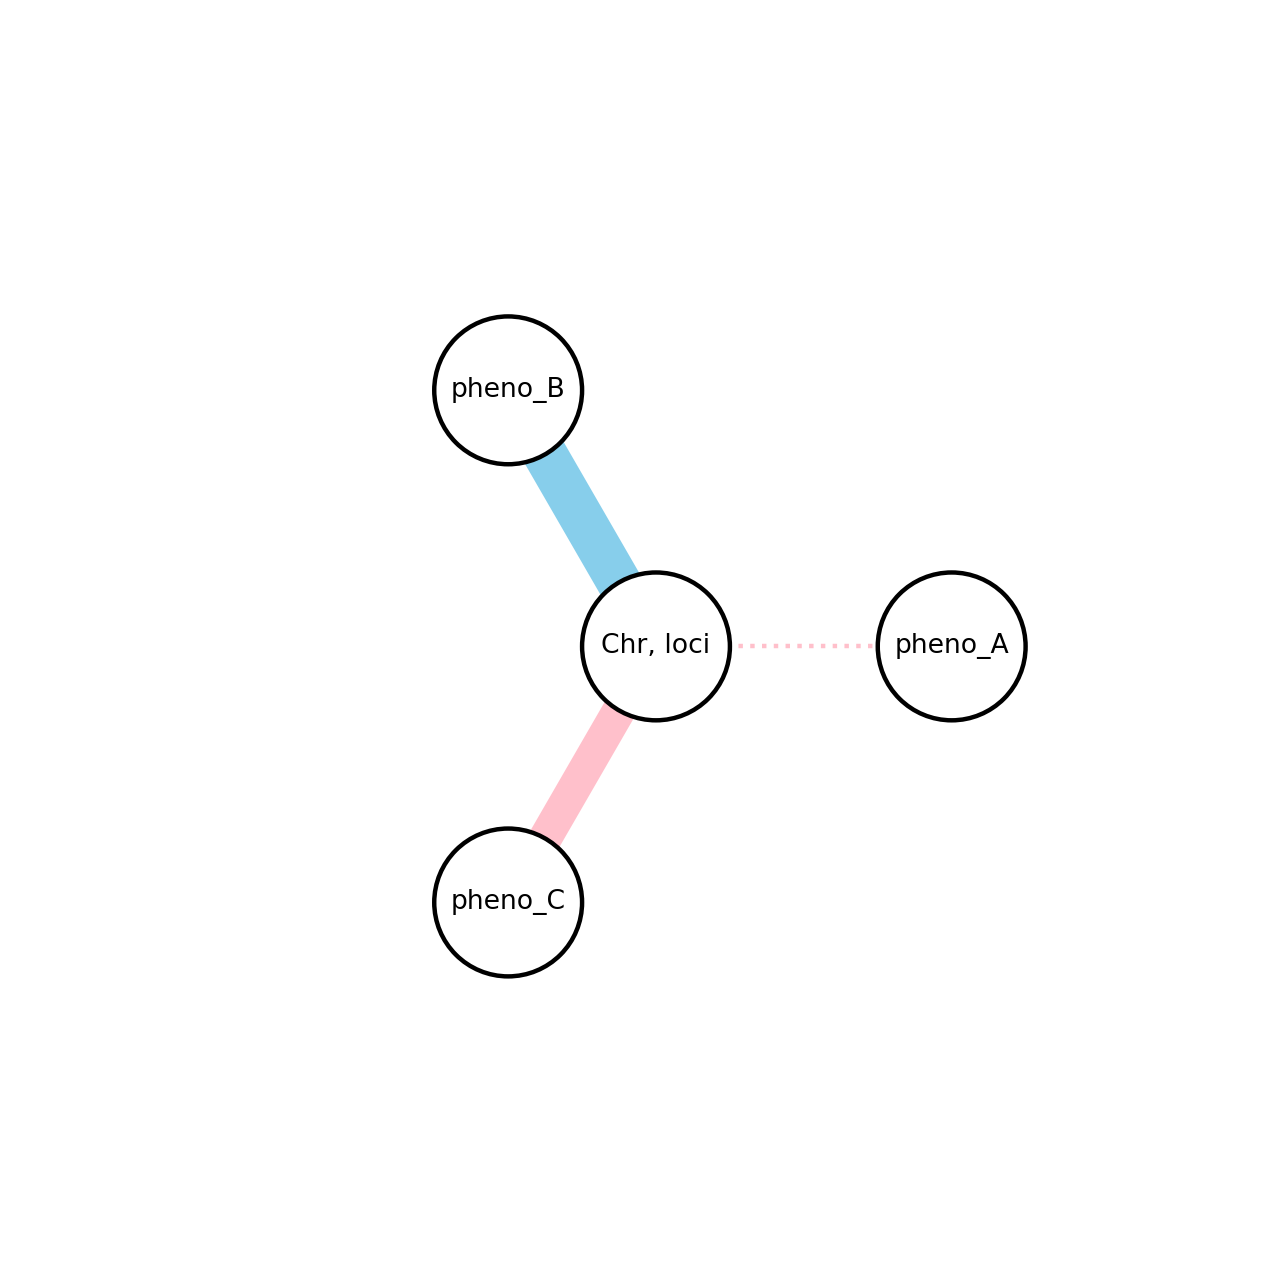

In [16]:
# test using made-up data
# circles_figure( "Chr, loci", ["pheno_A","pheno_B","pheno_C"], [-1,.75,.25], [True,True,False])
circles_figure( "Chr, loci", ["pheno_A","pheno_B","pheno_C"], [.1,-1,.75,], [False,True,True])
#plt.savefig("legend_sample",dpi=600)

<IPython.core.display.Javascript object>


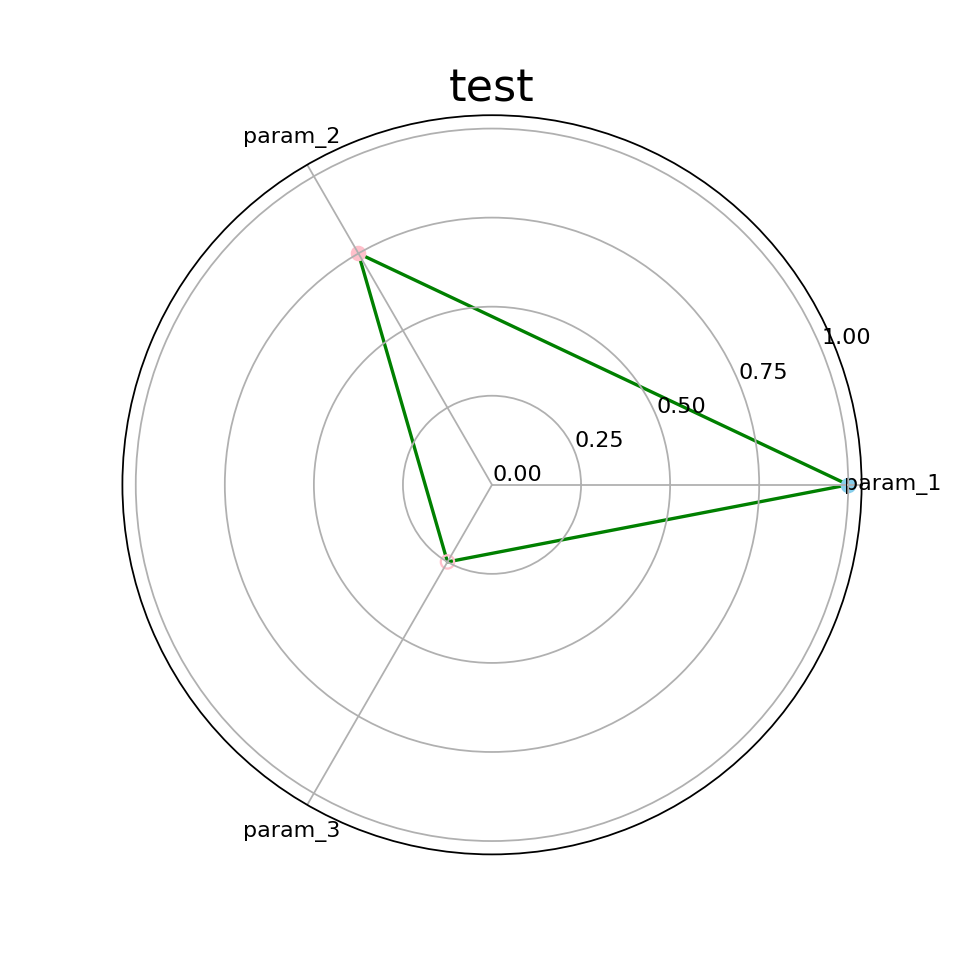

In [11]:
# test using made-up data
radar_plot( "test", ["param_1","param_2","param_3"], [-1,.75,.25], [True,True,False])

In [12]:
# pick one condition and one chromosome-region.
# for each parameter,
#   find the marker with the highest LOD score in that region
#   for that marker, compute the difference (AA-BB)
#
# return 
#   a list of LODs and 
#   a list of differences
#   a list of bools that are True where lod > threshold
def get_lod_and_dir_values( condition, chrom, start_pos, stop_pos, params ):
    result_lods = []
    result_dirs = []
    result_bools = []

    lod_df = all_lod_dataframes[condition]
    th_df = all_th_dataframes[condition]

    # for each parameter
    for i,param in enumerate(params):
        
        # find the raw data dataframe that includes this param
        raw_df = next(df for df in all_raw_dataframes[condition] if (param in df.columns))

        # find marker with maximum lod
        col = "LOD " + param
        lod_df_sub = lod_df[
                (lod_df["chr"] == chrom) & 
                (lod_df["pos (cM)"] >= start_pos) & 
                (lod_df["pos (cM)"] <= stop_pos)]
        max_lod_row = lod_df_sub.sort_values(col, ascending=False).index[0]
        max_lod_pos = lod_df_sub.loc[max_lod_row,"pos (cM)"]
        lod = lod_df_sub.loc[max_lod_row,col] 
        result_lods.append( lod )

        # check if the lod is above the threshold
        th = th_df.loc[0,param]
        result_bools.append( lod > th )
        
        # for this marker, find matching column in hapmap
        raw_df_chrom = raw_df.loc[:,raw_df.loc[0,:]==chrom]
        positions_in_chrom = np.array(list(set(raw_df_chrom.loc[1,:])))
        idx = (np.abs(positions_in_chrom - max_lod_pos)).argmin()
        best_match_position = positions_in_chrom[idx]
        matching_col = raw_df_chrom.loc[:,raw_df_chrom.loc[1,:] == best_match_position].columns[0]
        aa_bb_vals = raw_df_chrom.loc[:,matching_col]

        # compute AA-BB
        aa = np.nanmean(raw_df.loc[aa_bb_vals == "AA",param])
        bb = np.nanmean(raw_df.loc[aa_bb_vals == "BB",param])
        result_dirs.append( aa-bb )

    return result_lods, result_dirs, result_bools

<IPython.core.display.Javascript object>


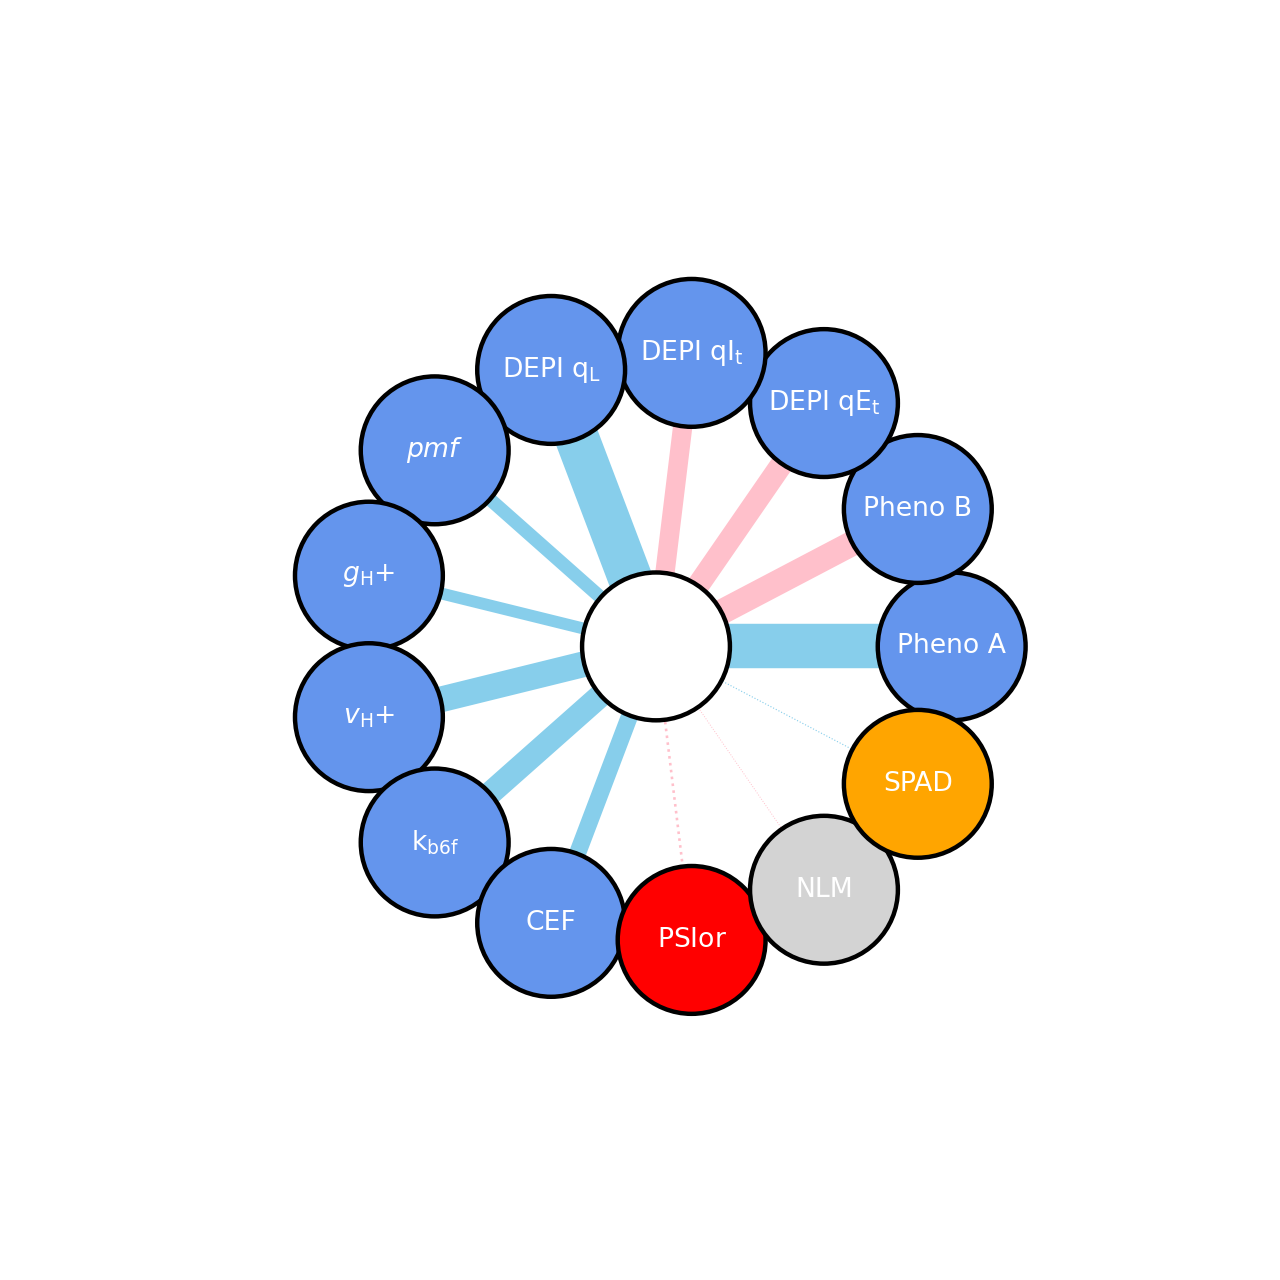

<IPython.core.display.Javascript object>


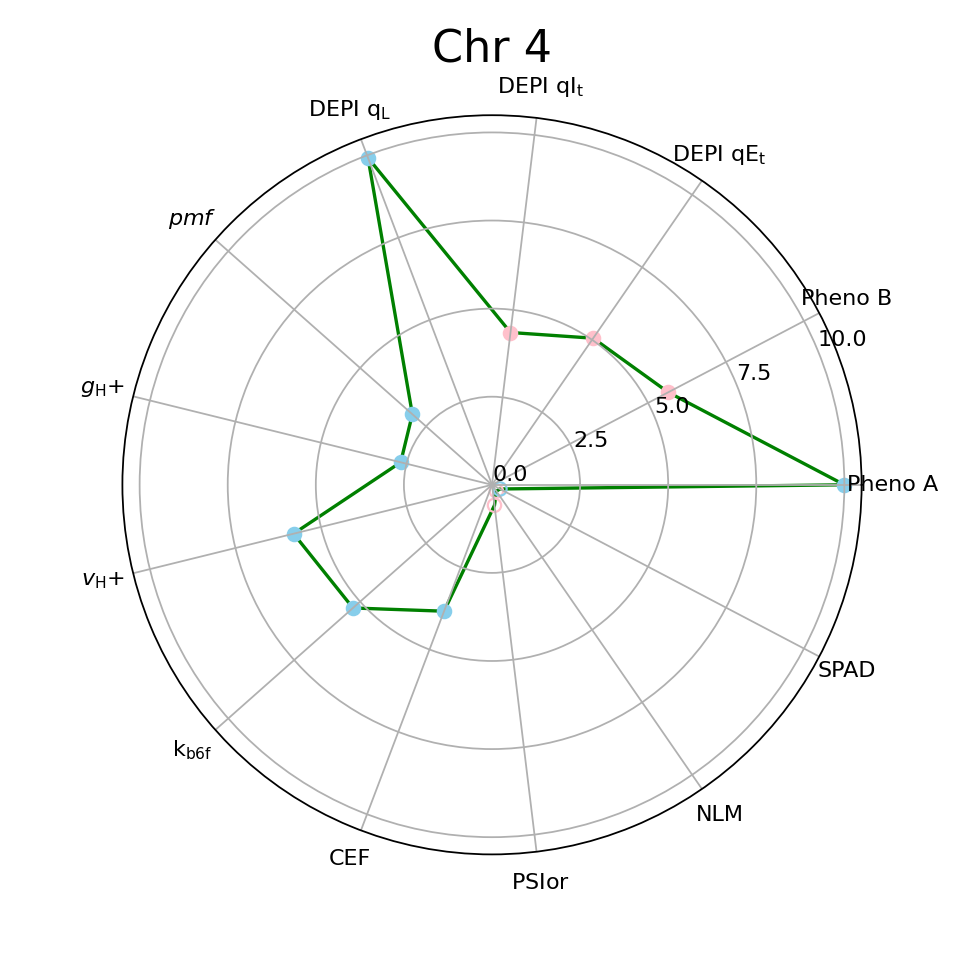

[10.9813770030978, 5.64868799120635, 5.05523450953127, 4.35390120522094, 9.92335828383471, 3.019555966008774, 2.6691400674430388, 5.799585307203771, 5.271747731006933, 3.836501661805163, 0.586144557910068, 0.218527760313398, 0.25518585968489427] [-0.08308885284039208, 0.4002140847063598, 0.11346340764394236, 0.29599389125827247, -0.10742915120410584, -0.0021498928529411765, -7.3265722222221825, -0.00035977583762298346, -75.43436170636272, -3.1327997489014415e-06, 0.05285887555266944, 0.05629271443567074, -0.8877111373474875] [True, True, True, True, True, True, True, True, True, True, False, False, False]


In [13]:
# build figures with real data

condition = "LT"
chrom = 4
start_pos = 59.04
stop_pos = 64.45


# find the highest LOD values and their directionalities
lod_values,dir_values,bool_values = get_lod_and_dir_values( condition, chrom,start_pos,stop_pos, param_order )

# combine dir and lod
values = lod_values * np.sign( dir_values )

# any value > vmax will have a thickness of max_connection_width
# if vmax is not given, it is set to max(abs(values))
circles_figure( "Chr " + str(chrom), param_order, values, bool_values, vmax=10)

# plt.savefig(condition +str(chrom)+"FAs_PS_18:2_final",dpi=600)

# any value > vmax will have a radius of vmax
# if vmax is not given, it is set to max(abs(values))
radar_plot( "Chr " + str(chrom), param_order, values, bool_values, vmax=10)

print(lod_values,dir_values,bool_values)

<IPython.core.display.Javascript object>


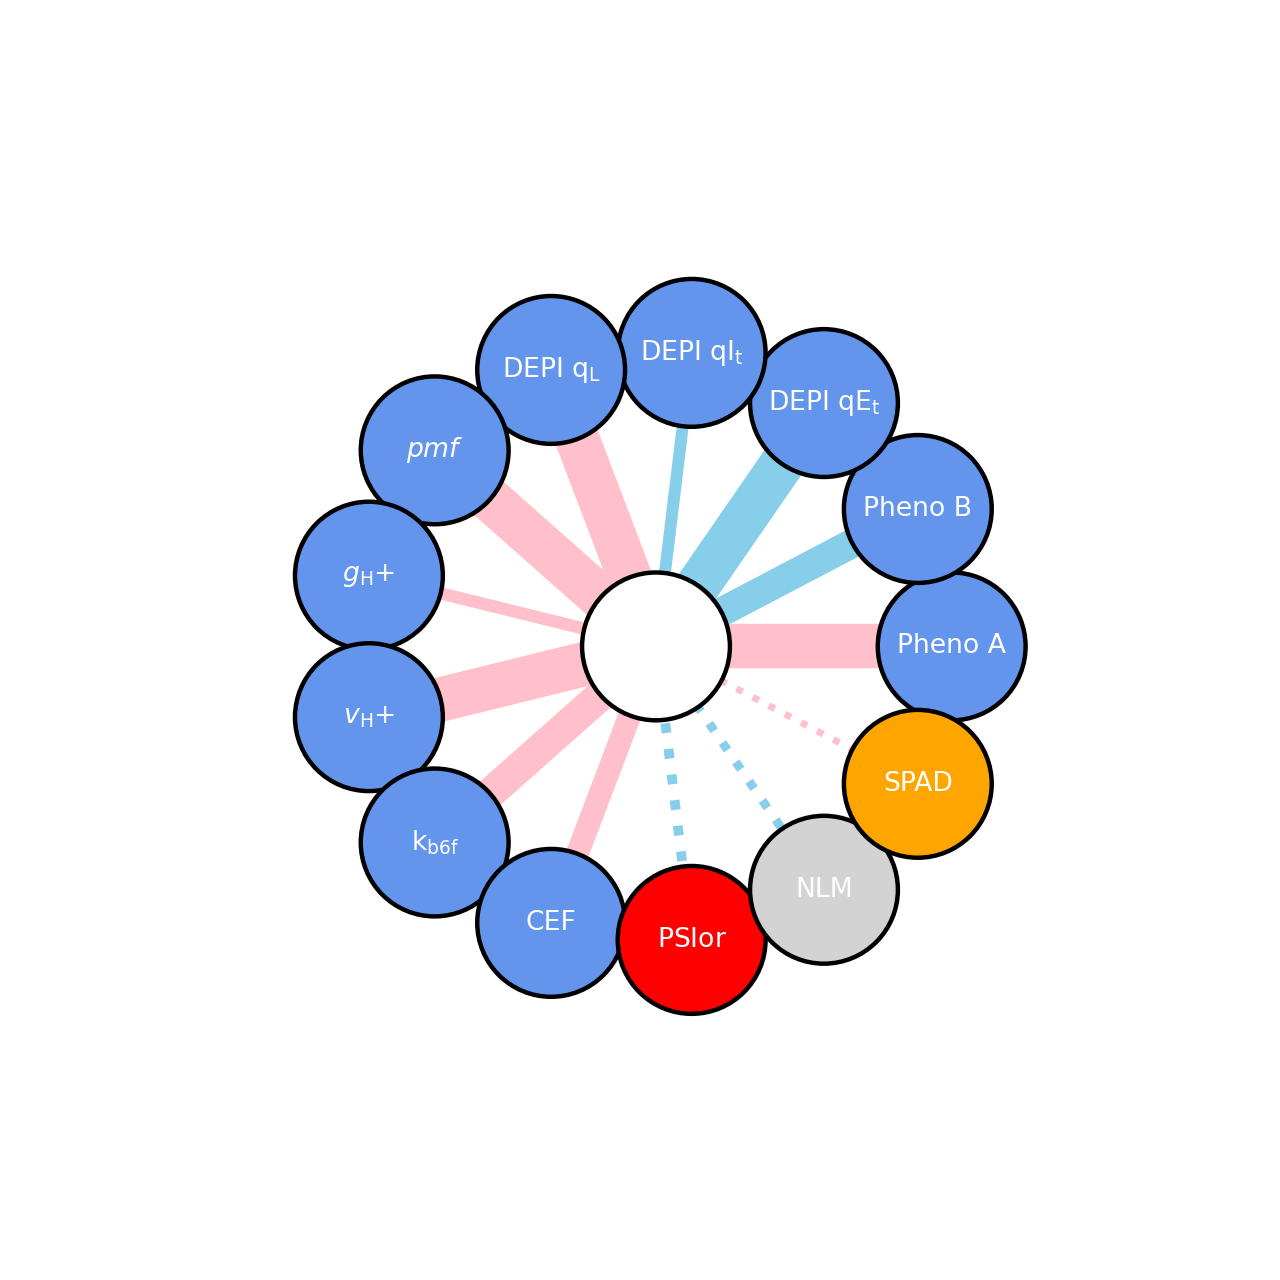

<IPython.core.display.Javascript object>


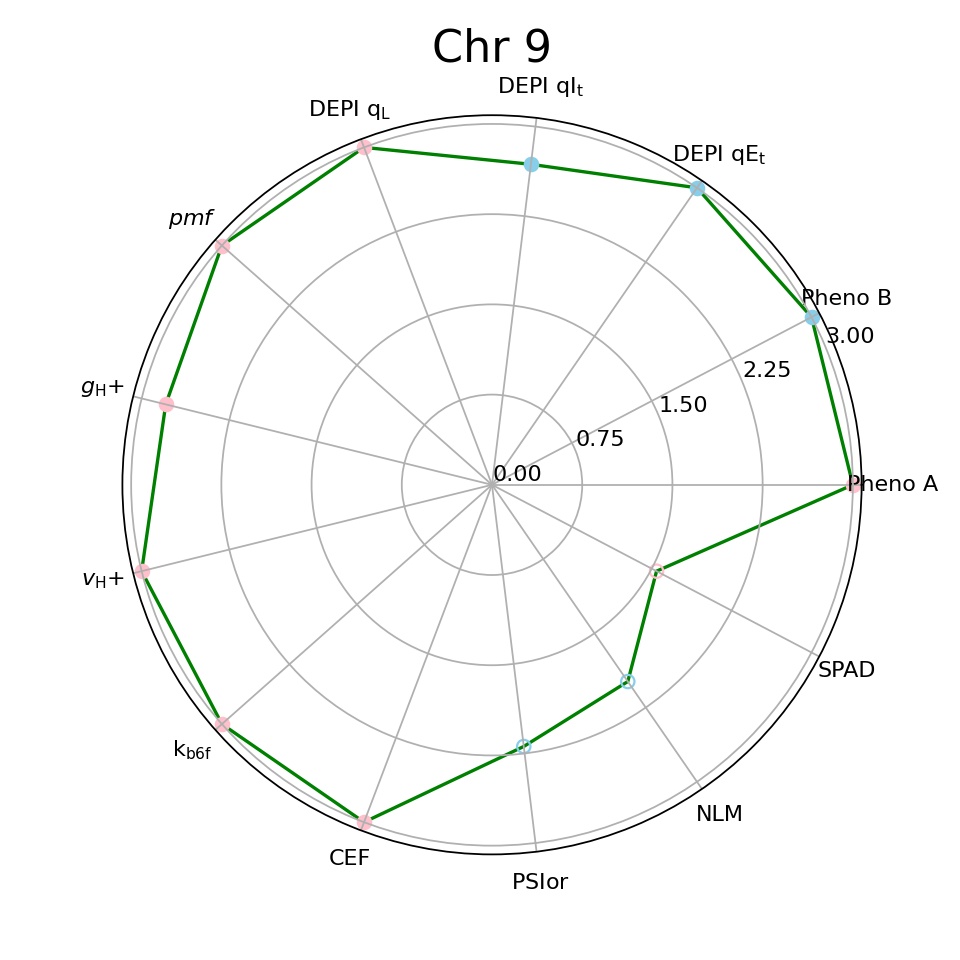

[17.2949523011382, 6.56826029221799, 11.2064129304215, 2.68418519617837, 18.6010889367405, 10.829139151467386, 2.793753856683156, 12.441798764582023, 6.9985545172720265, 5.159027098567309, 2.191354964499374, 1.98741020628639, 1.5450334285326688] [0.0986673869566917, -0.4094980598017104, -0.1949777046246699, -0.2238444909328099, 0.1386713544124587, 0.004047174912772589, 7.62196870846924, 0.0004972080268956323, 81.43213118176845, 3.5284090018034987e-06, -0.1118100052746418, -0.051704709517377045, 2.0880156739811824] [True, True, True, True, True, True, True, True, True, True, False, False, False]


In [14]:
# build figures with real data

condition = "LT"
chrom = 9
start_pos = 86.93
stop_pos = 104.15


# find the highest LOD values and their directionalities
lod_values,dir_values,bool_values = get_lod_and_dir_values( condition, chrom,start_pos,stop_pos, param_order )

# combine dir and lod
values = lod_values * np.sign( dir_values )

# any value > vmax will have a thickness of max_connection_width
# if vmax is not given, it is set to max(abs(values))
circles_figure( "Chr " + str(chrom), param_order, values, bool_values, vmax=10)

#plt.savefig(condition +str(chrom)+"_final",dpi=600)

# any value > vmax will have a radius of vmax
# if vmax is not given, it is set to max(abs(values))
radar_plot( "Chr " + str(chrom), param_order, values, bool_values, vmax=3)

print(lod_values,dir_values,bool_values)